# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
from keras.utils import plot_model

Using TensorFlow backend.


# Global variables

In [2]:
img_size = 224
batch_size = 32
epochs = 100
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4242
channels = 3
learning_rate = 0.00001

# Get classes and entries per classes

['Letter', 'Resume', 'Scientific', 'ADVE', 'Email', 'Report', 'News', 'Memo', 'Form', 'Note']
[241, 241, 241, 241, 241, 241, 241, 241, 241, 241]


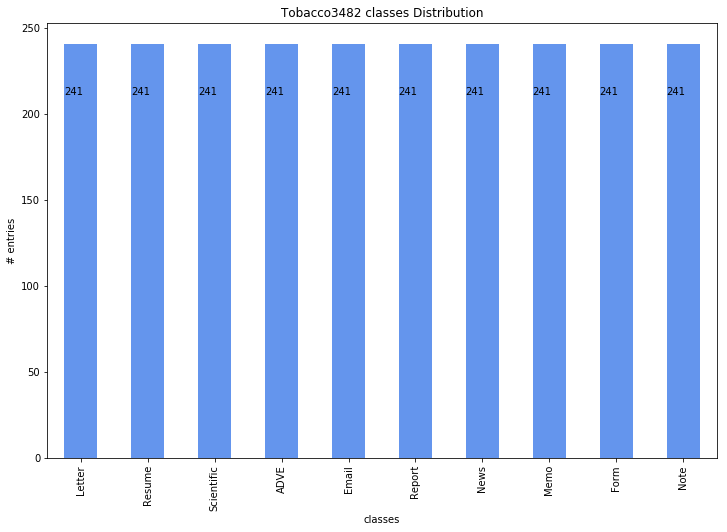

In [3]:
d = '../input/tobacco3482-jpg-balanced/Tobacco3482-jpg-balanced/'
PATH = '../'

classes = (os.listdir(d))

paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

nbEntries = []

for i in range(len(classes)):
    nbEntries.append(len(os.listdir(paths[i])))

#################################################
    
print(classes)
print(nbEntries)

df = pd.DataFrame({'classes':classes, 'entries':nbEntries})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 classes Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-30))

# Get all images

In [4]:
total_set = []
total_labels = []


for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            path = os.path.join(root, file)
            total_set.append(path)
            total_labels.append(root.split(os.path.sep)[-1])
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

../input/tobacco3482-jpg-balanced/Tobacco3482-jpg-balanced/Letter/10235850.jpg
GetClass :  Letter
Label :  Letter


# Plot data 

../input/tobacco3482-jpg-balanced/Tobacco3482-jpg-balanced/Email/529216154+-6154.jpg


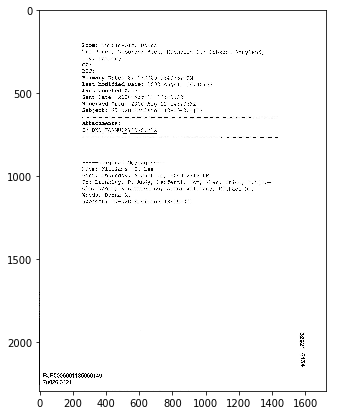

../input/tobacco3482-jpg-balanced/Tobacco3482-jpg-balanced/Form/2028676247.jpg


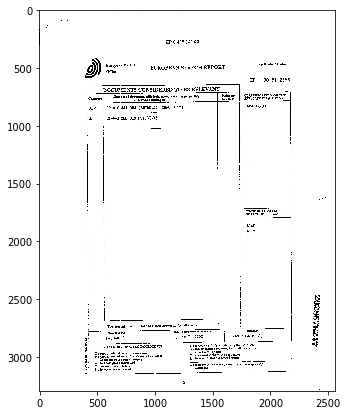

../input/tobacco3482-jpg-balanced/Tobacco3482-jpg-balanced/Scientific/2501138382.jpg


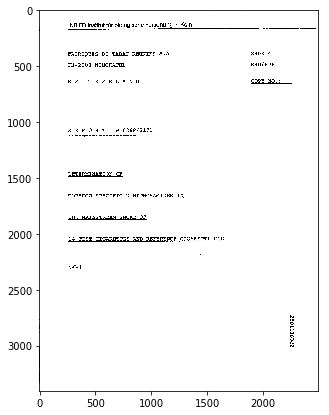

In [5]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()


# Sorting data in usable sets
![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [6]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])


../input/tobacco3482-jpg-balanced/Tobacco3482-jpg-balanced/Form/89113285_89113286.jpg
Form


# Visualize classes distribution (bar chart)

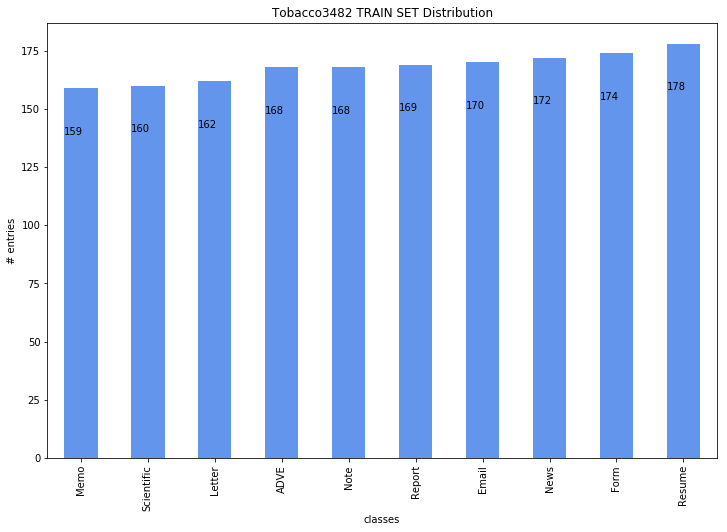

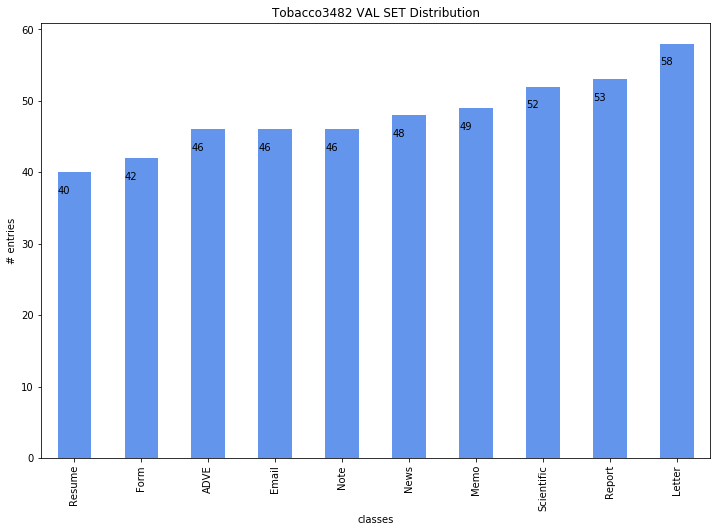

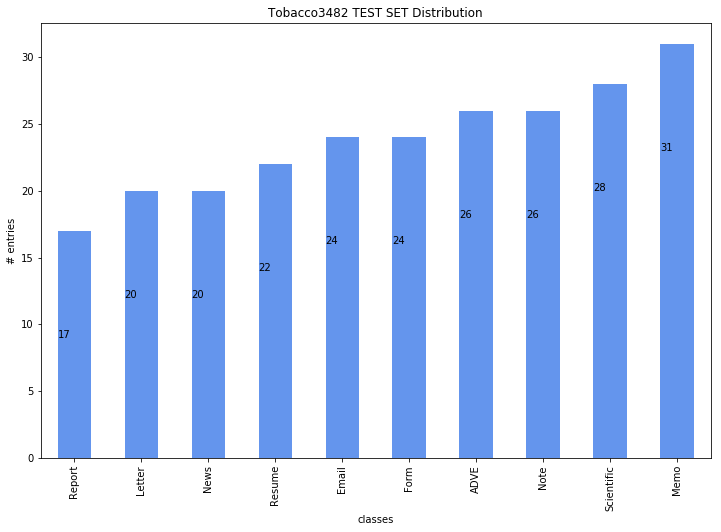

In [7]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

# Preprocess data (resize, transform to Numpy array and binarize)

[https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)

In [8]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)) :
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
data_train = process_images(train_set)
data_test = process_images(test_set)
data_val = process_images(val_set)

train images shape :  (1680, 224, 224, 3)
train labels shape :  (1680, 10)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
test shape :  (238, 224, 224, 3)
(238, 10)
valdiation shape :  (480, 224, 224, 3)
(480, 10)
Email
[0 1 0 0 0 0 0 0 0 0]
['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']


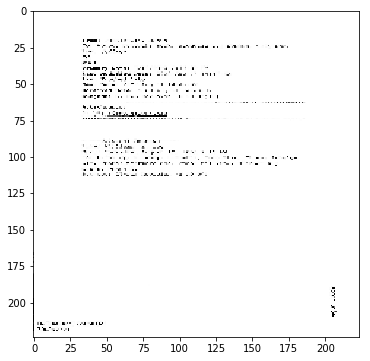

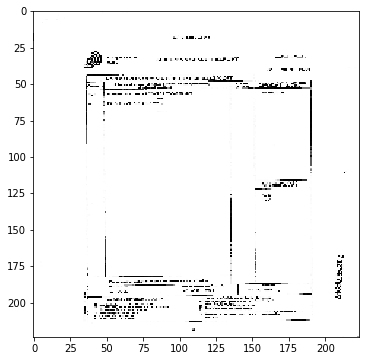

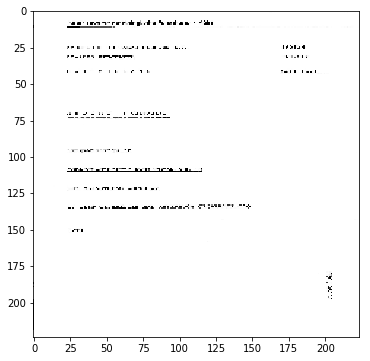

In [9]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(data_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)
print(x_train[0])

print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])

print(train_label[0])
print(y_train[0])
print(lb.classes_)

# Create base model (using pretrained CNN)

[https://keras.io/applications/](https://keras.io/applications/)

Trainable weights : TRUE

To "freeze" a layer means to exclude it from training. Allows to train the whole model and not only the last added layers --> 5/10% better accuracy. it takes about three to four times longer for training since there are way more parameters to train.


In [10]:
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

#for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____

# Create custom model
Base is VGG16, adding a flatten layer, a Dense layer and a dropout layer. Last Dense layer specify the number of classes

[https://keras.io/getting-started/sequential-model-guide/](https://keras.io/getting-started/sequential-model-guide/)

[https://keras.io/layers/core/](https://keras.io/layers/core/)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1290      
Total params: 17,927,370
Trainable params: 17,927,370
Non-trainable params: 0
_________________________________________________________________
Number of train

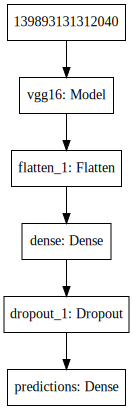

In [11]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Training the model

**Compile** : Configures the model for training.

**Fit** : Trains the model for a given number of epochs (iterations on a dataset).

[https://keras.io/models/model/](https://keras.io/models/model/)

In [12]:
model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1680 samples, validate on 480 samples
Epoch 1/100
1680/1680 [==============================] - 18s 11ms/step - loss: 5.2473 - acc: 0.1274 - val_loss: 2.2165 - val_acc: 0.1688
Epoch 2/100
1680/1680 [==============================] - 13s 8ms/step - loss: 2.1937 - acc: 0.2256 - val_loss: 1.9484 - val_acc: 0.3771
Epoch 3/100
1680/1680 [==============================] - 13s 8ms/step - loss: 1.9204 - acc: 0.3345 - val_loss: 1.6322 - val_acc: 0.4833
Epoch 4/100
1680/1680 [==============================] - 13s 8ms/step - loss: 1.6420 - acc: 0.4423 - val_loss: 1.3711 - val_acc: 0.5896
Epoch 5/100
1680/1680 [==============================] - 13s 8ms/step - loss: 1.3935 - acc: 0.5232 - val_loss: 1.1186 - val_acc: 0.6542
Epoch 6/100
1680/1680 [==============================] - 13s 8ms/step - loss: 1.1757 - acc: 0.6226 - val_loss: 1.0243 - val_acc: 0.6937
Epoch 7/100
1680/1680 [==============================] - 13s 8ms/step - loss: 1.0204 - a

# Plot accuracy and loss of trained model (line chart)

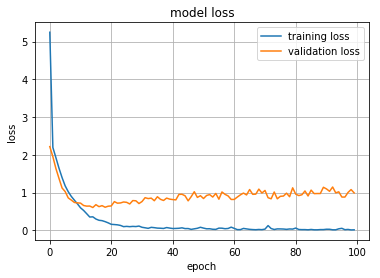

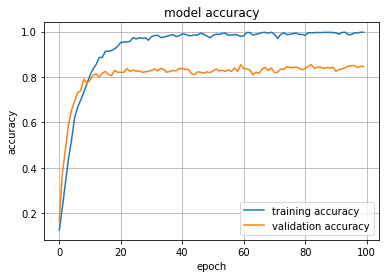

In [13]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

# Test prediction accuracy on test set

In [14]:
# combine predictions + average for better score ? 

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

238/238 [==============================] - 1s 4ms/step
Test loss: 1.2115425566414826
Test accuracy: 0.8403361349546609


# Save model
* the architecture of the model, allowing to re-create the model
* the weights of the model
* the training configuration (loss, optimizer)
* the state of the optimizer, allowing to resume training exactly where you left off.

In [15]:
model.save('trained_model.h5')

# Use model on test set

In [16]:
predictions = model.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))


238/238 [==============================] - 1s 3ms/step
Prediction :  Form    |   Real class :  Form    |   Result :  True
Prediction :  Note    |   Real class :  Note    |   Result :  True
Prediction :  Letter    |   Real class :  Memo    |   Result :  False
Prediction :  Note    |   Real class :  Note    |   Result :  True
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Form    |   Real class :  Form    |   Result :  True
Prediction :  Letter    |   Real class :  Report    |   Result :  False
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  ADVE    |   Real class :  ADVE    |   Result :  True
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Report    |   Real class :  Report    |   